# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## BUSINESS UNDERSTANDING

The goal of this project is to better understand what drives used car prices.

From a dealership perspective, pricing vehicles accurately is critical. 

Overpricing leads to slow turnover. 
Underpricing leaves money on the table. 

The business question becomes:

What vehicle attributes most strongly influence price, and does that influence change across price tiers?

Reframed as a data problem:

- Use supervised learning (regression) to model vehicle price.
- Identify the features that contribute most to predicted price.
- Evaluate whether different price segments behave differently.
- Provide interpretable insights that can inform inventory and pricing strategy.

The objective is not just predictive accuracy, but insight into how the used car market behaves.

# Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

## DATA UNDERSTANDING

Before modeling, I explored the dataset to understand its structure and quality.

Key steps included:

- Reviewing missing values across columns
- Examining feature cardinality (number of unique levels)
- Investigating extreme price values (including $0 listings)
- Visualizing price distributions (raw and trimmed)
- Exploring the structure of the `model` field

Some important findings:

- A large number of vehicles are listed at $0, which appear to be placeholder values.
- The price distribution is heavily skewed.
- The `model` column contains many noisy or inconsistent values.

These observations guided the cleaning and feature engineering steps.

In [1]:
##########################################
# Imports
##########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


##########################################
# Load Dataset
##########################################

df = pd.read_csv("data/vehicles.csv")

raw_df = df.copy()


In [2]:
##########################################
# Column Summary and Missing Values
##########################################

missing_summary = (
    raw_df
    .isna()
    .sum()
    .to_frame(name = "Missing Count")
)

missing_summary = missing_summary.sort_values(
    by = "Missing Count",
    ascending = False
)

display(missing_summary)


,Missing Count
size,306361
cylinders,177678
condition,174104
VIN,161042
drive,130567
paint_color,130203
type,92858
manufacturer,17646
title_status,8242
model,5277


In [3]:
##########################################
# Feature Cardinality (Unique Levels)
##########################################

exclude_cols = ["price", "VIN", "id"]

cardinality_df = (
    pd.DataFrame(
        {
            "Unique Levels" : raw_df.drop(columns = exclude_cols).nunique()
        }
    )
    .sort_values(
        by = "Unique Levels",
        ascending = False
    )
)

display(cardinality_df)



,Unique Levels
odometer,104870
model,29649
region,404
year,114
state,51
manufacturer,42
type,13
paint_color,12
cylinders,8
condition,6


In [4]:
##########################################
# Extreme Price Check
##########################################

print("Minimum Price: ", raw_df["price"].min())

print("Maximum Price: ", raw_df["price"].max())


print("\n")
print("Count < 1k: ", (raw_df["price"] < 1000).sum())
print("Count > 100k: ", (raw_df["price"] > 100000).sum())



Minimum Price:  0
Maximum Price:  3736928711


Count < 1k:  46315
Count > 100k:  655


In [5]:
##########################################
# Sub-1k Price Investigation
##########################################


low_price_df = raw_df[raw_df["price"] < 1000]

display(low_price_df["price"].describe())

print("\n")

display(low_price_df["price"].value_counts().head())



count    46315.000000
mean       101.538961
std        216.886632
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        999.000000
Name: price, dtype: float64

price
0      32895
1       1951
500     1021
99       815
700      333
Name: count, dtype: int64

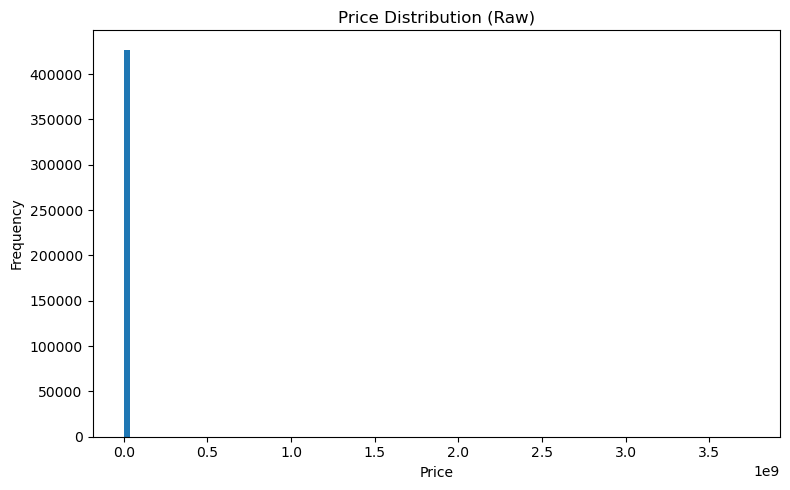

In [6]:

##########################################
# Price Histogram (Raw)
##########################################


fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(raw_df["price"], bins = 100)

ax.set_title("Price Distribution (Raw)")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()



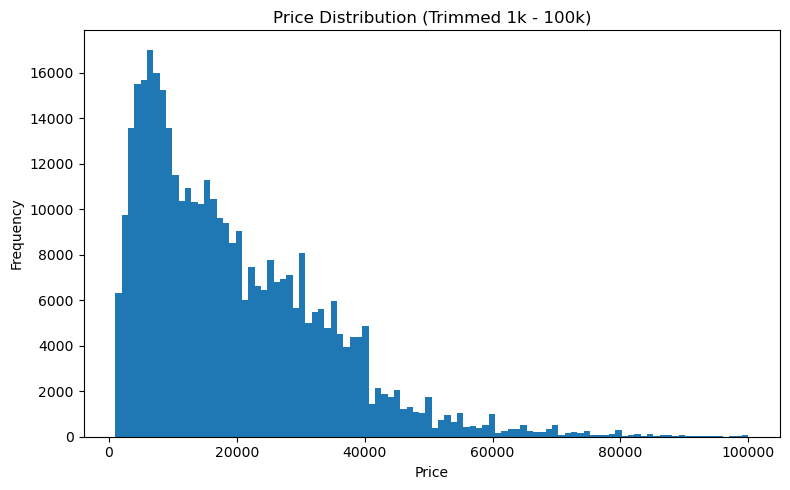

In [7]:

##########################################
# Price Histogram (1k - 100k)
##########################################

df_trim = raw_df[(raw_df["price"] >= 1000) & (raw_df["price"] <= 100000)]

fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(df_trim["price"], bins = 100)

ax.set_title("Price Distribution (Trimmed 1k - 100k)")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()



In [8]:


##########################################
# Model First Token Preview
##########################################


raw_df["model_first_token"] = (
    raw_df["model"]
    .astype(str)
    .str.lower()
    .str.split()
    .str[0]
)

token_counts = raw_df["model_first_token"].value_counts()

display(token_counts.head(10))

print("Unique first tokens: ", raw_df["model_first_token"].nunique())



model_first_token
silverado    17113
f-150        10362
1500          9205
sierra        8571
wrangler      8070
grand         7435
civic         5750
tacoma        5710
f150          5566
accord        5483
Name: count, dtype: int64

Unique first tokens:  4439


# Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

## DATA PREPARATION

The dataset was filtered and prepared for modeling:

Filtering:

- Restricted price to 1,000 - 100,000
- Restricted odometer to 100 - 500,000 miles
- Removed vehicles older than 1990
- Dropped rows missing year, price, or odometer

Feature Engineering:

- Created vehicle age from year
- Applied log transformation to price and odometer
- Standardized categorical missing features
- Cleaned the `model` field and reduced it to first-token feature
- Grouped infrequent model tokens into "other model"

Final feature groups:

- Numeric: age, log_odometer
- Categorical: manufacturer, title_status, type, fuel, transmission, drive, condition, cylinders, paint_color, state, region, model_clean_first_token, size

The data was then split into training and test sets for modeling.

In [9]:
##########################################
# Price, Odometer, and Age
##########################################


df = df[(df["price"] >= 1000) & (df["price"] <= 100_000)]

df = df[(df["odometer"] >= 100) & (df["odometer"] <= 500_000)]

df = df.dropna(subset = ["year", "odometer", "price"])

df = df[df["year"] >= 1990]

df["age"] = 2026 - df["year"]


##########################################
# Log Price and Log Odometer
##########################################


df["log_price"] = np.log(df["price"])

df["log_odometer"] = np.log(df["odometer"])


##########################################
# Base Categorical Columns and Cleaning
##########################################


base_categorical_cols = [
    "manufacturer",
    "title_status",
    "type",
    "fuel",
    "transmission",
    "drive",
    "condition",
    "cylinders",
    "paint_color",
    "state",
    "region",
    "size"
]

for col in base_categorical_cols:
    df[col] = df[col].astype(str).fillna("missing")
    df[col] = df[col].replace("nan", "missing")



##########################################
# Model Clean First Token
##########################################


df["model_clean"] = (
    df["model"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex = True)
)

df["model_clean_first_token"] = df["model_clean"].str.split().str[0]


model_counts = df["model_clean_first_token"].value_counts()


model_whitelist = model_counts[model_counts >= 100].index


df["model_clean_first_token"] = np.where(
    df["model_clean_first_token"].isin(model_whitelist),
    df["model_clean_first_token"],
    "other_model"
)


##########################################
# Numeric and Categorical Columns
##########################################


numeric_cols = ["age", "log_odometer"]

categorical_cols = base_categorical_cols + ["model_clean_first_token"]


feature_list = numeric_cols + categorical_cols



##########################################
# Define X and y 
##########################################


X = df[feature_list]

y = df["log_price"]


##########################################
# Train Test Split
##########################################



X_train, X_test, y_train, y_test = (
    train_test_split(
        X,
        y,
        test_size = 0.2,
        random_state = 42
    )
)



# Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## MODELING

Several regression approaches were evaluated in order to understand how model complexity affects performance:

- Linear Regression (baseline)
- Polynomial Linear Regression (degree sweep)
- Ridge Regression (alpha sweep)
- Ridge + Polynomial Features with 5-fold cross-validation

Models were compared using:

- Train and test Mean Squared Error (MSE)
- Test R^2
- Cross-validation performance for hyperparameter selection

The goal was to find a model that improves fit without overfitting the data.

The final selected model was a Ridge Regression with:

- Polynomial degree = 4
- Alpha = 0.1

This configuration provided strong test performance while maintaining stability across folds. 

Increasing the degree beyond 4 produced only marginal gains, suggesting diminishing returns in added complexity.

In [10]:
##########################################
##########################################
#
#          Linear Regression
#
##########################################
##########################################


lin_results_list = []


##########################################
# Linear Regression Pipeline
##########################################


lin_numeric = (
    Pipeline(
        [
            ("standard_scaler", StandardScaler())
        ]
    )
)


lin_categorical = (
    Pipeline(
        [
            ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
        ]
    )
)



lin_preprocessor = (
    ColumnTransformer(
        [
            ("numeric", lin_numeric, numeric_cols),
            ("categorical", lin_categorical, categorical_cols)
        ]
    )
)



lin_pipeline = (
    Pipeline(
        [
            ("preprocessor", lin_preprocessor),
            ("model", LinearRegression())
        ]
    )
)


lin_pipeline.fit(X_train, y_train)


##########################################
# Make Predictions
##########################################


train_preds = lin_pipeline.predict(X_train)
test_preds = lin_pipeline.predict(X_test)


train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)




##########################################
# Add Results to List
##########################################

lin_results_list.append(
    {
        "Lin Reg Train MSE" : train_mse,
        "Lin Reg Test MSE" : test_mse
    }
)


##########################################
# Save Results to DataFrame
##########################################
    
lin_df = pd.DataFrame(lin_results_list)




##########################################
# Audit
##########################################

display(
    lin_df
    [
        [
            "Lin Reg Train MSE",
            "Lin Reg Test MSE"
        ]
    ]
)


,Lin Reg Train MSE,Lin Reg Test MSE
0,0.141836,0.142815


In [11]:
##########################################
##########################################
#
#         Linear Regression
#       Polynomial Degree Sweep
#
#            CALCULATION
#
##########################################
##########################################



degrees = [1, 2, 3, 4, 5]

poly_results_list = []


##########################################
# Polynomial Degree Sweep
##########################################

for degree in degrees:


    poly_numeric = (
        Pipeline(
            [
                ("polynomial_features", PolynomialFeatures(degree = degree, include_bias = False)),
                ("standard_scaler", StandardScaler())
            ]
        )
    )


    poly_categorical = (
        Pipeline(
            [
                ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
            ]
        )
    )
      

    poly_preprocessor = (
        ColumnTransformer(
            [
                ("numeric", poly_numeric, numeric_cols),
                ("categorical", poly_categorical, categorical_cols)
            ]
        )
    )


    poly_pipeline = (
        Pipeline(
            [
                ("preprocessor", poly_preprocessor),
                ("model", LinearRegression())
            ]
        )
    )


    poly_pipeline.fit(X_train, y_train)

    ##########################################
    # Make Predictions
    ##########################################
    

    train_preds = poly_pipeline.predict(X_train)
    test_preds = poly_pipeline.predict(X_test)
    
    
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)



    ##########################################
    # Add Results to List
    ##########################################
    
    poly_results_list.append(
        {
            "Poly Degree" : degree,
            "Poly Train MSE" : train_mse,
            "Poly Test MSE" : test_mse
        }
    )


##########################################
# Save List to DataFrame 
##########################################

poly_df = pd.DataFrame(poly_results_list)




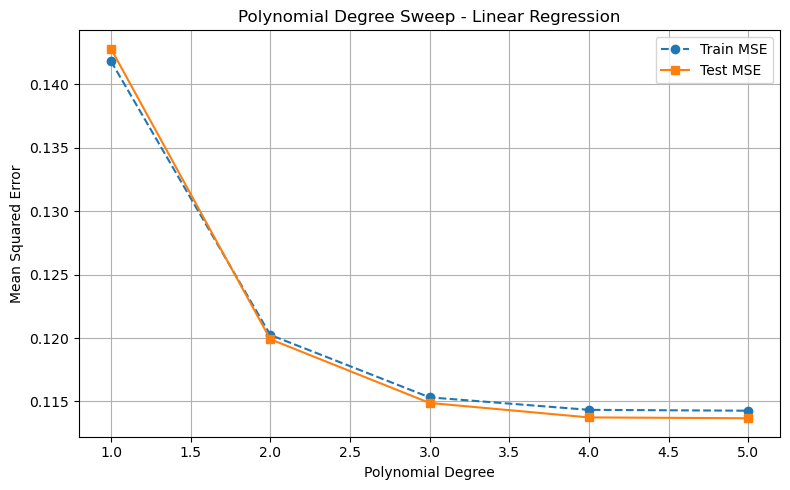

,Poly Train MSE,Poly Test MSE
Poly Degree,,
1,0.141836,0.142815
2,0.120247,0.119908
3,0.115323,0.114882
4,0.114338,0.113741
5,0.114269,0.113675


In [12]:
##########################################
##########################################
#
#         Linear Regression
#       Polynomial Degree Sweep 
#
#                PLOT
#
##########################################
##########################################


fig, ax = plt.subplots(figsize = (8, 5))



ax.plot(
    poly_df["Poly Degree"],
    poly_df["Poly Train MSE"],
    linestyle = "--",
    marker = "o",
    label = "Train MSE"
)


ax.plot(
    poly_df["Poly Degree"],
    poly_df["Poly Test MSE"],
    linestyle = "-",
    marker = "s",
    label = "Test MSE"
)

##########################################

ax.set_title("Polynomial Degree Sweep - Linear Regression")
ax.set_xlabel("Polynomial Degree")
ax.set_ylabel("Mean Squared Error")

ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

##########################################

display(
    poly_df
    .set_index("Poly Degree")
    [
        [
            "Poly Train MSE",
            "Poly Test MSE"
        ]
    ]
)


In [13]:
##########################################
##########################################
#
#         Ridge Regression
#           Alpha Sweep
#
#            CALCULATION
#
##########################################
##########################################


alphas = [0.01, 0.1, 1, 10, 100]

ridge_results_list = []


##########################################
# Ridge Alpha Sweep
##########################################

for alpha in alphas: 

    ridge_numeric = (
        Pipeline(
            [
                ("standard_scaler", StandardScaler())
            ]
        )
    )

    ridge_categorical = (
        Pipeline(
            [
                ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
            ]
        )
    )

    ridge_preprocessor = (
        ColumnTransformer(
            [
                ("numeric", ridge_numeric, numeric_cols),
                ("categorical", ridge_categorical, categorical_cols)
            ]
        )
    )
 
    ridge_pipeline = (
        Pipeline(
            [
                ("preprocessor", ridge_preprocessor),
                ("model", Ridge(alpha = alpha))
            ]
        )
    )

    ridge_pipeline.fit(X_train, y_train)

    ##########################################
    # Make Predictions
    ##########################################


    train_preds = ridge_pipeline.predict(X_train)
    test_preds = ridge_pipeline.predict(X_test)


    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)


    
    ##########################################
    # Add Results to List
    ##########################################
    ridge_results_list.append(
        {
            "Alpha" : alpha,
            "Ridge Train MSE" : train_mse,
            "Ridge Test MSE" : test_mse
        }
    )



##########################################
# Save List to DataFrame
##########################################

ridge_df = pd.DataFrame(ridge_results_list)




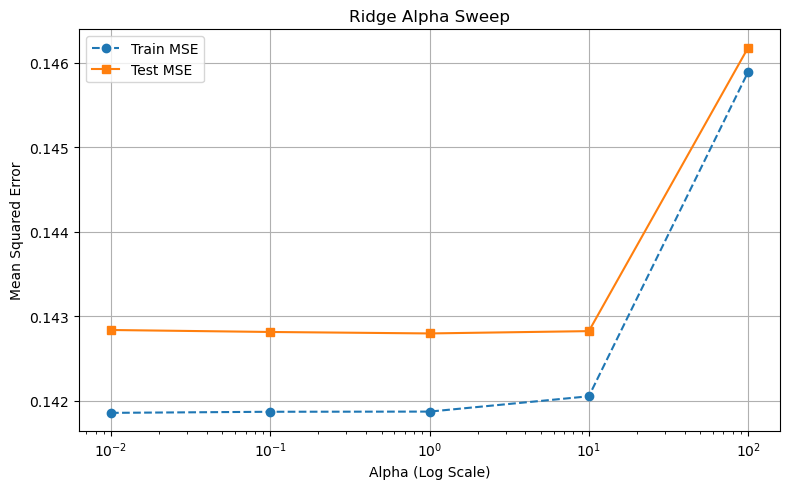

,Ridge Train MSE,Ridge Test MSE
Alpha,,
0.01,0.141857,0.142837
0.10,0.141870,0.142814
1.00,0.141872,0.142797
10.00,0.142053,0.142824
100.00,0.145890,0.146177


In [14]:
##########################################
##########################################
#
#         Ridge Regression
#           Alpha Sweep
#
#              PLOT
#
##########################################
##########################################



fig, ax = plt.subplots(figsize = (8, 5))



ax.semilogx(
    ridge_df["Alpha"],
    ridge_df["Ridge Train MSE"],
    linestyle = "--",
    marker = "o",
    label = "Train MSE"
)


ax.semilogx(
    ridge_df["Alpha"],
    ridge_df["Ridge Test MSE"],
    linestyle = "-",
    marker = "s",
    label = "Test MSE"
)

##########################################

ax.set_title("Ridge Alpha Sweep")
ax.set_xlabel("Alpha (Log Scale)")
ax.set_ylabel("Mean Squared Error")

ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

##########################################

display(
    ridge_df
    .set_index("Alpha")
    [
        [
            "Ridge Train MSE",
            "Ridge Test MSE"
        ]
    ]
)




In [15]:
##########################################
##########################################
#
#         Ridge Regression
#    Polynomial Degree and Alpha Sweep
#      with 5-fold Cross Validation
#
#            CALCULATION
#
##########################################
##########################################


degrees = [1, 2, 3, 4, 5]

alphas = [0.01, 0.1, 1, 10, 100]

ridge_cv_results_list = []


##########################################
# Ridge Polynomial and Alpha CV Sweep
##########################################


for degree in degrees:

    ridge_cv_numeric = (
        Pipeline(
            [
                ("polynomial_features", PolynomialFeatures(degree = degree, include_bias = False)),
                ("standard_scaler", StandardScaler())
            ]
        )
    )

    ridge_cv_categorical = (
        Pipeline(
            [
                ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
            ]
        )
    ) 
 
    ridge_cv_preprocessor = (
        ColumnTransformer(
            [
                ("numeric", ridge_cv_numeric, numeric_cols),
                ("categorical", ridge_cv_categorical, categorical_cols)
            ]
        )
    )

    ridge_cv_pipeline = (
        Pipeline(
            [
                ("preprocessor", ridge_cv_preprocessor),
                ("model", Ridge())
            ]
        )
    )
    

    ##########################################
    # CV Grid
    ##########################################

    
    param_grid = {
        "model__alpha" : alphas
    }

    ridge_cv_grid = (
        GridSearchCV(
            ridge_cv_pipeline,
            param_grid = param_grid,
            scoring = "neg_mean_squared_error",
            cv = 5
        )
    )

    ridge_cv_grid.fit(X_train, y_train)

    best_alpha = ridge_cv_grid.best_params_["model__alpha"]


    ##########################################
    # Make Predictions
    ##########################################
    

    train_preds = ridge_cv_grid.predict(X_train)
    test_preds = ridge_cv_grid.predict(X_test)


    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)

    

    ##########################################
    # Add Results to List
    ##########################################
    
    ridge_cv_results_list.append(
        {
            "Poly Degree" : degree,
            "Best Alpha" : best_alpha,
            "Ridge CV Train MSE" : train_mse,
            "Ridge CV Test MSE" : test_mse
        }
    )


##########################################
# Save List to DataFrame
##########################################

ridge_cv_df = pd.DataFrame(ridge_cv_results_list)





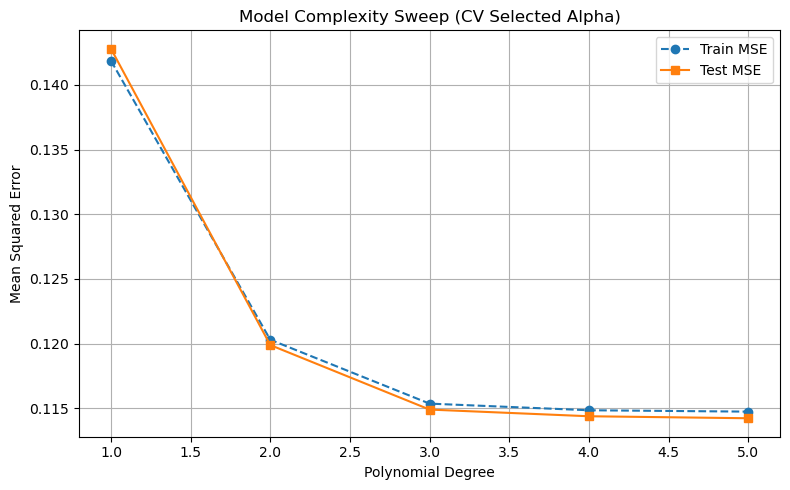

,Best Alpha,Ridge CV Train MSE,Ridge CV Test MSE
Poly Degree,,,
1,1.00,0.141873,0.142797
2,1.00,0.120293,0.119882
3,0.01,0.115353,0.114893
4,0.10,0.114840,0.114377
5,0.01,0.114734,0.114222


In [16]:
##########################################
##########################################
#
#         Ridge Regression
#    Polynomial Degree and Alpha Sweep
#      with 5-fold Cross Validation
#
#              PLOT
#
##########################################
##########################################


fig, ax = plt.subplots(figsize = (8, 5))



ax.plot(
    ridge_cv_df["Poly Degree"],
    ridge_cv_df["Ridge CV Train MSE"],
    linestyle = "--",
    marker = "o", 
    label = "Train MSE"
)



ax.plot(
    ridge_cv_df["Poly Degree"],
    ridge_cv_df["Ridge CV Test MSE"],
    linestyle = "-",
    marker = "s",
    label = "Test MSE"
)

##########################################

ax.set_title("Model Complexity Sweep (CV Selected Alpha)")
ax.set_xlabel("Polynomial Degree")
ax.set_ylabel("Mean Squared Error")

ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

##########################################

display(
    ridge_cv_df
    .set_index("Poly Degree")
    [
        [
            "Best Alpha",
            "Ridge CV Train MSE",
            "Ridge CV Test MSE"
        ]
    ]
)



# Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

## EVALUATION

After selecting the final ridge model (degree = 4, alpha = 0.1), performance was examined both globally and across price tiers.

### Global Observations:

- Age is the strongest overall predictor of price (P.I. = 0.48).
- Model identity is the second most influential feature (P.I. = 0.25).
- Mileage contributes consistently (P.I. = 0.17).
- Manufacturer and fuel contribute smaller but measurable effects (P.I. = 0.09 and 0.04).
- The residual plot suggests larger prediction errors at both the lower and upper ends of the price spectrum, indicating the model fits mid-range vehicles more consistently than vehicles at the extremes. 
- The model captures the broad pricing structure but does not fully explain extreme values.

### Tiered Observations:

When retrained within price bands, feature importance shifts:

#### 0 - 10k Tier

- Age dominates.
- Mileage remains relevant.
- Model and manufacturer play smaller roles.


#### 10k - 20k Tier

- Model identity becomes the strongest predictor.
- Age and mileage remain influential.
- Manufacturer importance increases.


#### 20k - 30k Tier

- Model and manufacturer are primary drivers.
- Age and mileage become secondary.


#### 30k - 40k Tier

- Model remains strong.
- Manufacturer and age have similar magnitude.
- Mileage influence declines.
- Residual volatility is lowest in this band.


#### 40k+ Tier

- Model and manufacturer remain important.
- Fuel type increases substantially in influence.
- Age and mileage play smaller relative roles.


Overall, feature importance varies meaningfully across price tiers, reinforcing that the used car market does not behave as a single uniform pricing system.





In [17]:
##########################################
##########################################
#
#      Global Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#               CALCULATION
#
##########################################
##########################################


degree = 4
alpha = 0.1


##########################################
# Global Model
##########################################



global_numeric = (
    Pipeline(
        [
            ("polynomial_features", PolynomialFeatures(degree = degree, include_bias = False)),
            ("standard_scaler", StandardScaler())
        ]
    )
)

global_categorical = (
    Pipeline(
        [
            ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
        ]
    )
)   

global_preprocessor = (
    ColumnTransformer(
        [
            ("numeric", global_numeric, numeric_cols),
            ("categorical", global_categorical, categorical_cols)
        ]
    )
)

global_pipeline = (
    Pipeline(
        [
            ("preprocessor", global_preprocessor),
            ("model", Ridge(alpha = alpha))
        ]
    )
)


global_pipeline.fit(X_train, y_train)


##########################################
# Make Predictions
##########################################


train_preds = global_pipeline.predict(X_train)
test_preds = global_pipeline.predict(X_test)
                
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

global_residuals = y_test - test_preds



##########################################
# Save Results to DataFrame
##########################################


global_results_df = (
    pd.DataFrame(
        {
            "Global Actual Log Price" : y_test,
            "Global Predicted Log Price" : test_preds,
            "Global Residuals" : global_residuals
        }
    )
)




In [18]:
##########################################
##########################################
#
#      Global Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#    PERMUTATION IMPORTANCE CALCULATION
#
##########################################
##########################################



##########################################
# Calculate Global Permutation Importance
##########################################

global_perm = permutation_importance(
    global_pipeline,
    X_test,
    y_test,
    n_repeats = 5,
    random_state = 42,
    scoring = "r2"
)


##########################################
# Save Global Permutation Importance to Series
##########################################

global_importance = (
    pd.Series(
        global_perm.importances_mean,
        index = numeric_cols + categorical_cols
    )
    .sort_values(ascending = False)
)




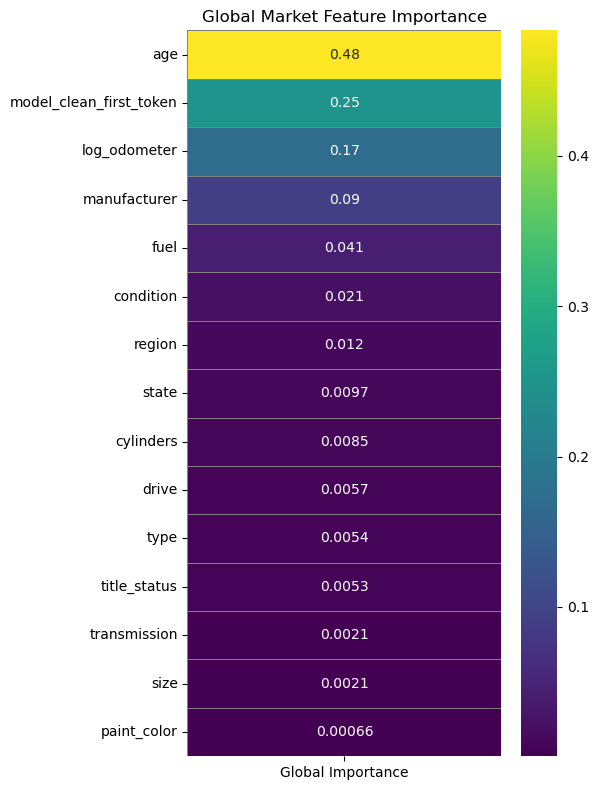

In [19]:
##########################################
##########################################
#
#      Global Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#      PERMUTATION IMPORTANCE HEATMAP
#
##########################################
##########################################


fig, ax = plt.subplots(figsize = (6, 8))


sns.heatmap(
    global_importance.to_frame(name = "Global Importance"),
    annot = True,
    cmap = "viridis",
    linewidth = 0.5,
    linecolor = "gray",
    ax = ax
)


##########################################



ax.set_title("Global Market Feature Importance")
ax.set_xlabel("")
ax.set_ylabel("")


plt.tight_layout()
plt.show()



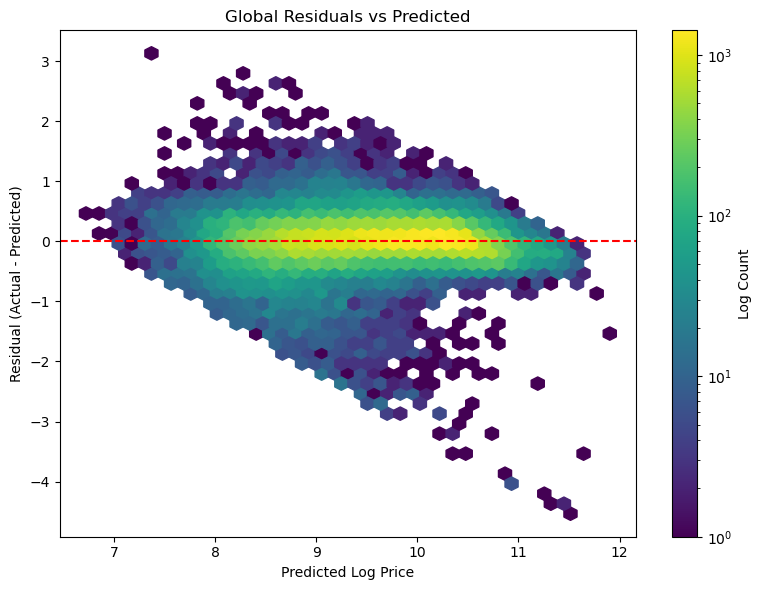

In [20]:
##########################################
##########################################
#
#      Global Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#            RESIDUAL HEXBIN
#
##########################################
##########################################


global_preds = global_results_df["Global Predicted Log Price"]

global_residuals = global_results_df["Global Residuals"]


##########################################


fig, ax = plt.subplots(figsize = (8, 6))

    
hb = ax.hexbin(    
    global_preds,
    global_residuals,
    gridsize = 40,
    bins = "log",
    cmap = "viridis"
)

##########################################


ax.axhline(0, color = "red", linestyle = "--")

ax.set_title("Global Residuals vs Predicted")
ax.set_xlabel("Predicted Log Price")
ax.set_ylabel("Residual (Actual - Predicted)")


fig.colorbar(hb, ax = ax, label = "Log Count")

plt.tight_layout()
plt.show()




In [21]:
##########################################
##########################################
#
#    Price Tiered Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#    PERMUTATION IMPORTANCE CALCULATION
#
##########################################
##########################################


degree = 4
alpha = 0.1

tier_performance_list = []

tier_importance_list = []


price_tiers = [
    (1000, 10000, "0 - 10k"),
    (10000, 20000, "10k - 20k"),
    (20000, 30000, "20k - 30k"),
    (30000, 40000, "30k - 40k"),
    (40000, 100000, "40k+")
]


##########################################
# Global Model Retrained in Price Tiers
##########################################


for min_price, max_price, tier_label in price_tiers:

    price_tier_df = df[(df["price"] >= min_price) & (df["price"] < max_price)].copy()


    
    tier_X = price_tier_df[feature_list]
    tier_y = price_tier_df["log_price"]

    
    tier_X_train, tier_X_test, tier_y_train, tier_y_test = (
        train_test_split(
            tier_X,
            tier_y,
            test_size = 0.2,
            random_state = 42
        )
    )

    tier_numeric = (
        Pipeline(
            [
                ("polynomial_features", PolynomialFeatures(degree = degree, include_bias = False)),
                ("standard_scaler", StandardScaler())
            ]
        )
    )
        
    tier_categorical = (
        Pipeline(
            [
                ("one_hot_encoder", OneHotEncoder(handle_unknown = "ignore"))
            ]
        )
    )     
     
    tier_preprocessor = (
        ColumnTransformer(
            [
                ("numeric", tier_numeric, numeric_cols),
                ("categorical", tier_categorical, categorical_cols)
            ]
        )
    )
    
    tier_pipeline = (
        Pipeline(
            [
                ("preprocessor", tier_preprocessor),
                ("model", Ridge(alpha = alpha))
            ]
        )
    )
        
    
    tier_pipeline.fit(tier_X_train, tier_y_train)


    ##########################################
    # Make Predictions
    ##########################################
    
    
    tier_train_preds = tier_pipeline.predict(tier_X_train)
    tier_test_preds = tier_pipeline.predict(tier_X_test)
                        
    tier_train_mse = mean_squared_error(tier_y_train, tier_train_preds)
    tier_test_mse = mean_squared_error(tier_y_test, tier_test_preds)
    
    tier_train_r2 = r2_score(tier_y_train, tier_train_preds)
    tier_test_r2 = r2_score(tier_y_test, tier_test_preds)



    tier_residuals = tier_y_test - tier_test_preds

    tier_residual_std = tier_residuals.std()
     



    ##########################################
    # Write Performance Rows to List
    ##########################################
    
    tier_performance_list.append(
        {
            "Tier" : tier_label,
            "Tier Rows" : len(price_tier_df),
            "Tier Train MSE" : tier_train_mse,
            "Tier Test MSE" : tier_test_mse,
            "Tier Train r2": tier_train_r2,
            "Tier Test r2" : tier_test_r2,
            "Tier Residual Std" : tier_residual_std
        }
    )



    ##########################################
    # Calculate Price Tier Permutation Importance
    ##########################################
    

    tier_perm = permutation_importance(
        tier_pipeline,
        tier_X_test,
        tier_y_test,
        n_repeats = 5,
        random_state = 42,
        scoring = "r2"
    )


    
    ##########################################
    # Save Price Tier Permutation Importance to Series
    ##########################################
    
    tier_importance_series = (
        pd.Series(
            tier_perm.importances_mean,
            index = feature_list,
            name = tier_label
        )
        .sort_values(ascending = False)
    )


    

    ##########################################
    # Write Price Tier Permutation Importance to List
    ##########################################
    
    tier_importance_list.append(tier_importance_series)




##########################################
# Save Price Tier Performance to DataFrame
##########################################

tier_performance_df = pd.DataFrame(tier_performance_list)



##########################################
# Save Price Tier Permutation Importance to DataFrame
##########################################

tier_importance_df = pd.concat(tier_importance_list, axis = 1)





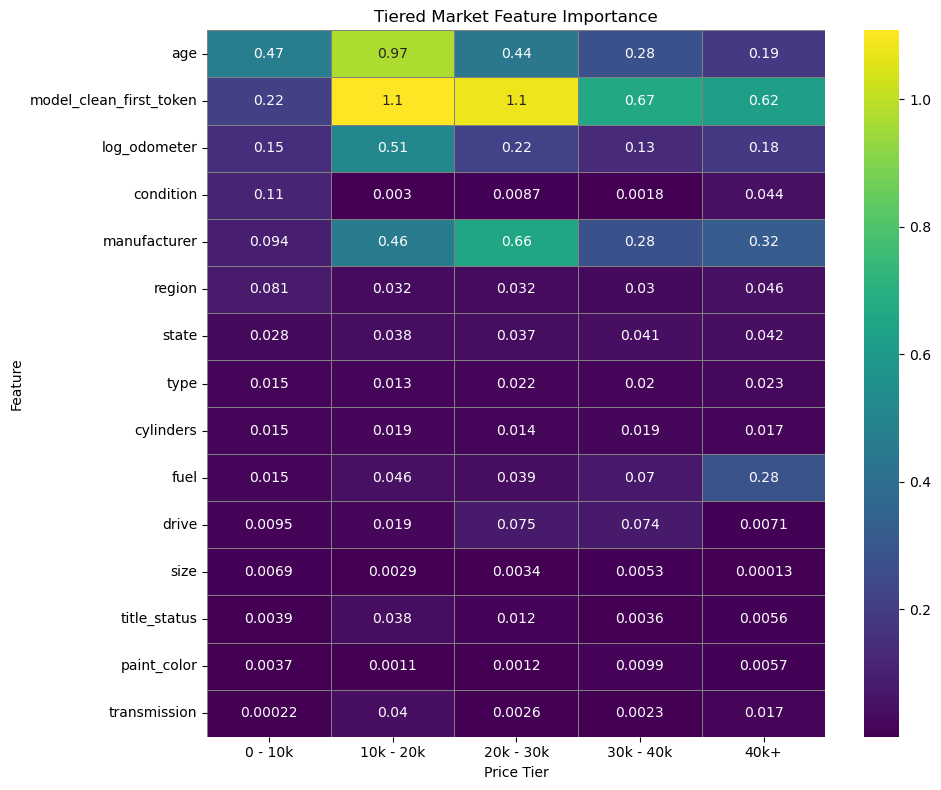

In [22]:
##########################################
##########################################
#
#    Price Tiered Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#    PERMUTATION IMPORTANCE HEATMAP
#
##########################################
##########################################


fig, ax = plt.subplots(figsize = (10, 8))


sns.heatmap(
    tier_importance_df,
    annot = True,
    cmap = "viridis",
    linewidth = 0.5,
    linecolor = "gray",
    ax = ax
)

ax.set_title("Tiered Market Feature Importance")
ax.set_xlabel("Price Tier")
ax.set_ylabel("Feature")


plt.tight_layout()
plt.show()


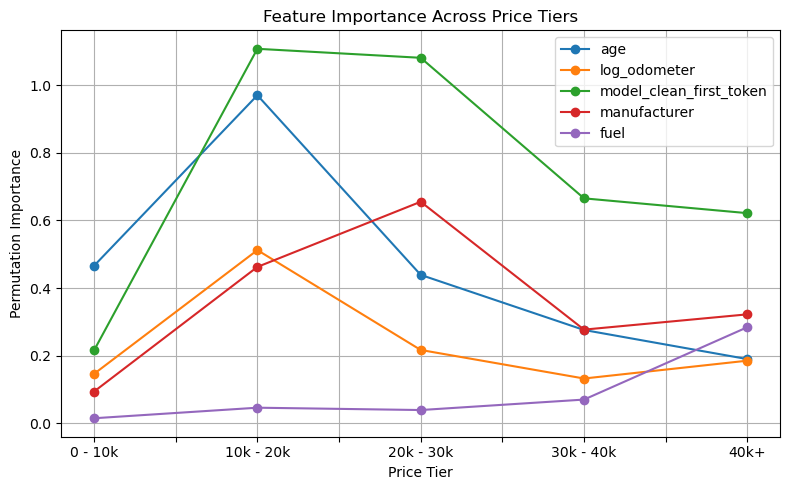

,age,log_odometer,model_clean_first_token,manufacturer,fuel
0 - 10k,0.465832,0.145986,0.215507,0.093653,0.014653
10k - 20k,0.970323,0.512104,1.107716,0.462382,0.045866
20k - 30k,0.438831,0.216685,1.081115,0.655188,0.038945
30k - 40k,0.275818,0.132229,0.665267,0.276851,0.069893
40k+,0.189668,0.184980,0.621480,0.322057,0.284022


In [23]:
##########################################
##########################################
#
#    Price Tiered Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
#    TIERED FEATURE IMPORTANCE PLOT
#
##########################################
##########################################

core_features = ["age", "log_odometer", "model_clean_first_token", "manufacturer", "fuel"]


core_importance = tier_importance_df.loc[core_features]


core_importance_t = core_importance.T



fig, ax = plt.subplots(figsize = (8, 5))



core_importance_t.plot(
    marker = "o",
    ax = ax
)

  
ax.set_title("Feature Importance Across Price Tiers")
ax.set_xlabel("Price Tier")
ax.set_ylabel("Permutation Importance")

ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()



display(core_importance_t)


            

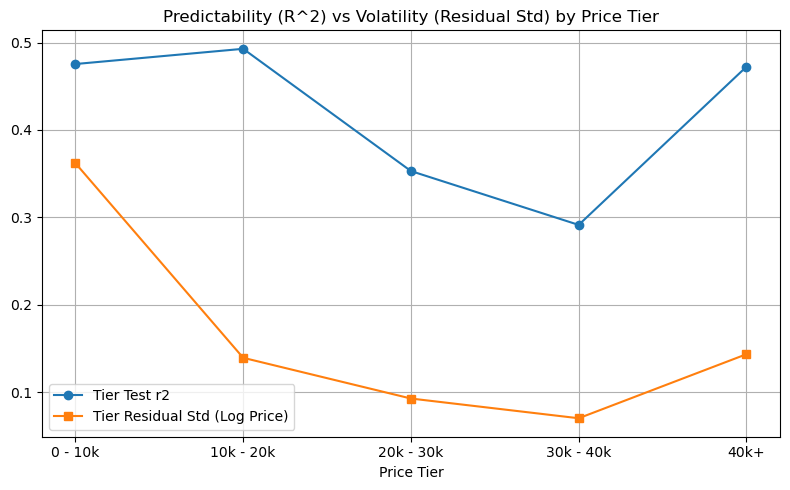

,Tier Test r2,Tier Residual Std
Tier,,
0 - 10k,0.475390,0.361976
10k - 20k,0.492808,0.139308
20k - 30k,0.352949,0.092705
30k - 40k,0.291344,0.070143
40k+,0.472317,0.143410


In [24]:
##########################################
##########################################
#
#    Price Tiered Ridge Regression Model
#          Polynomial Degree = 4
#            Alpha Value = 0.1
#
# TIERED PREDICTIBILITY VS VOLATILITY PLOT
#
##########################################
##########################################

tier_order = ["0 - 10k", "10k - 20k", "20k - 30k", "30k - 40k", "40k+"]



tier_performance_df["Tier"] = pd.Categorical(
    tier_performance_df["Tier"],
    categories = tier_order,
    ordered = True
)


tier_performance_df = tier_performance_df.sort_values("Tier")



fig, ax = plt.subplots(figsize = (8, 5))



ax.plot(
    tier_performance_df["Tier"],
    tier_performance_df["Tier Test r2"],
    marker = "o",
    label = "Tier Test r2"
)


ax.plot(
    tier_performance_df["Tier"],
    tier_performance_df["Tier Residual Std"],
    marker = "s",
    label = "Tier Residual Std (Log Price)"
)


ax.set_title("Predictability (R^2) vs Volatility (Residual Std) by Price Tier")
ax.set_xlabel("Price Tier")

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()



display(
    tier_performance_df
    .set_index("Tier")
    [
        [
            "Tier Test r2",
            "Tier Residual Std"
        ]
    ]
)



# Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

## DEPLOYMENT

The analysis indicates that pricing behavior differs across market segments, and a single pricing rule may not reflect those structural differences. This supports the idea that tier-specific pricing adjustments may be more effective than a single global pricing formula.

### Practical Insights by Tier

#### 0 - 10k (Utility Segment)

Vehicles in this range are primarily influenced by age and mileage. Buyers appear focused on reliability and remaining lifespan. Brand prestige and fuel type have limited pricing power in this segment. 

#### 10k - 20k (Transitional Segment)

Model identity becomes the dominant driver. Buyers begin differentiating between specific models and trims rather than evaluating vehicles solely on condition. This tier shows the highest predictability (R^2 = 0.49), suggesting pricing strategies can be tighter and more systematic. 

#### 20k - 30k (Brand-Sensitive Segment)

Model and manufacturer together drive pricing. Brand differences become increasingly important. Age and mileage matter, but identity now outweighs wear. 

#### 30k - 40k (Stable Segment)

Residual volatility is lowest in this tier. Vehicles are generally newer and lower mileage, so pricing variation appears more tied to trim level, options, and brand differences than mechanical condition.

#### 40k+ (Premium Segment)

Fuel type becomes significantly influential. This likely reflects the presence of hybrid, electric, luxury, and performance vehicles, where fuel type meaningfully impacts value. Age and mileage matter less relative to vehicle identity. 





## FINAL SUMMARY

This project demonstrates that used car pricing is structured but not uniform. While age and mileage remain consistent drivers of value, model identity, manufacturer, and fuel type gain influence in higher price tiers. A single global pricing rule does not fully capture these shifts. 

By combining regression modeling with tier-specific analysis, we move beyond prediction alone and toward understanding how pricing behavior changes across segments. This framework can support more informed inventory decisions and more disciplined pricing strategies. 

![helllo](images/car_salesman.png)